In [1]:
import sys 
sys.path.append('/data/conghao001/diffusion_model/latent-diffusion')
sys.path.append('../')

In [2]:
# set this before importing torch
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="3"


In [3]:
from moler_ldm import LatentDiffusion
import torch
from dataset import LincsDataset, MolerDataset
from torch_geometric.loader import DataLoader
from omegaconf import OmegaConf
from model_utils import get_params
from tqdm import tqdm
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from datetime import datetime
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.modules.diffusionmodules.util import make_ddim_sampling_parameters, make_ddim_timesteps, noise_like
from rdkit.Chem import Draw


/data/conghao001/anaconda3/envs/drug_gen/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-30 23:42:26.020045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
device = torch.device("cuda:0")

# Unconditional VAE model

In [4]:
ckpt_path = 'lightning_logs/2023-05-04_12_17_02.544383/epochepoch=97-dropout=0.95-val_lossval/loss=0.35.ckpt'
checkpoint = torch.load(ckpt_path, map_location = device)
checkpoint

{'epoch': 97,
 'global_step': 77812,
 'pytorch-lightning_version': '1.8.1',
 'state_dict': OrderedDict([('betas',
               tensor([0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0010, 0.0010, 0.0010, 0.0010,
                       0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013,
                       0.0013, 0.0014, 0.0014, 0.0014, 0.0014, 0.0015, 0.0015, 0.0015, 0.0016,
                       0.0016, 0.0016, 0.0017, 0.0017, 0.0017, 0.0018, 0.0018, 0.0018, 0.0019,
                       0.0019, 0.0019, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0022, 0.0022,
                       0.0022, 0.0023, 0.0023, 0.0024, 0.0024, 0.0024, 0.0025, 0.0025, 0.0026,
                       0.0026, 0.0026, 0.0027, 0.0027, 0.0028, 0.0028, 0.0029, 0.0029, 0.0029,
                       0.0030, 0.0030, 0.0031, 0.0031, 0.0032, 0.0032, 0.0033, 0.0033, 0.0033,
                       0.0034, 0.0034, 0.0035, 0.0035, 0.0036, 0.0036, 0.0037, 0.0037, 0.0038,
                       0.0038, 

In [5]:
checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])

In [6]:
checkpoint['callbacks']

{"EarlyStopping{'monitor': 'val/loss_simple_ema', 'mode': 'min'}": {'wait_count': 0,
  'stopped_epoch': 0,
  'best_score': tensor(0.3516, device='cuda:2'),
  'patience': 10},
 "ModelCheckpoint{'monitor': 'val/loss', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None, 'save_on_train_epoch_end': True}": {'monitor': 'val/loss',
  'best_model_score': tensor(0.3511, device='cuda:2'),
  'best_model_path': '/data/conghao001/FYP/DrugDiscovery/ldm/lightning_logs/2023-05-04_12_17_02.544383/epochepoch=97-dropoutargs.gen_step_drop_probability=0.00-val_lossval/loss=0.35.ckpt',
  'current_score': tensor(0.3511, device='cuda:2'),
  'dirpath': '/data/conghao001/FYP/DrugDiscovery/ldm/lightning_logs/2023-05-04_12_17_02.544383',
  'best_k_models': {'/data/conghao001/FYP/DrugDiscovery/ldm/lightning_logs/2023-05-04_12_17_02.544383/epochepoch=97-dropoutargs.gen_step_drop_probability=0.00-val_lossval/loss=0.35.ckpt': tensor(0.3511, device='cuda:2')},
  'kth_best_model_p

In [7]:
config_file = '/data/conghao001/FYP/DrugDiscovery/ldm/lightning_logs/2023-05-04_12_17_02.544383/logs_2023-05-04_12_17_02.544383/version_0/ddim_vae_uncon.yml'
config = OmegaConf.load(config_file)
ldm_params = config['model']['params']


In [8]:
# args
batch_size = 1
NUM_WORKERS = 4
train_split1 = "train_0"
valid_split = "valid_0"

layer_type = "FiLMConv"
model_architecture = 'vae'
gradient_clip_val = 1.0
max_lr = 1e-5
gen_step_drop_probability = 0
use_oclr_scheduler = True
using_cyclical_anneal = False
use_clamp_log_var = False

raw_moler_trace_dataset_parent_folder = "/data/ongh0068/guacamol/trace_dir"
# raw_moler_trace_dataset_parent_folder = "/data/ongh0068/l1000/TRACE_DIR"
output_pyg_trace_dataset_parent_folder = (
    "/data/ongh0068/l1000/already_batched"
)

In [9]:
dataset = LincsDataset(
    root="/data/ongh0068",
    raw_moler_trace_dataset_parent_folder="/data/ongh0068/guacamol/trace_dir",
    output_pyg_trace_dataset_parent_folder="/data/ongh0068/l1000/already_batched",
    split="valid_0",
    gene_exp_controls_file_path="/data/ongh0068/l1000/lincs/robust_normalized_controls.npz",
    gene_exp_tumour_file_path="/data/ongh0068/l1000/lincs/robust_normalized_tumors.npz",
    lincs_csv_file_path="/data/ongh0068/l1000/lincs/experiments_filtered.csv",
)

Loading controls gene expression...
Loading tumour gene expression...
Loading csv...


In [10]:
dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        # sampler=train_sampler,
        follow_batch=[
            "correct_edge_choices",
            "correct_edge_types",
            "valid_edge_choices",
            "valid_attachment_point_choices",
            "correct_attachment_point_choice",
            "correct_node_type_choices",
            "original_graph_x",
            "correct_first_node_type_choices",
        ],
        num_workers=NUM_WORKERS,
        # prefetch_factor=0,
    )

In [11]:
one = next(iter(dataloader))
one

MolerDataBatch(x=[16413, 59], edge_index=[2, 33312], original_graph_edge_features=[65434], original_graph_node_categorical_features=[29966], focus_node=[1000], partial_graph_edge_features=[33312], edge_features=[7327, 3], correct_edge_choices=[7327], correct_edge_choices_batch=[7327], correct_edge_choices_ptr=[1001], num_correct_edge_choices=[1000], stop_node_label=[1000], valid_edge_choices=[7327, 2], valid_edge_choices_batch=[7327], valid_edge_choices_ptr=[1001], valid_edge_types=[512, 3], correct_edge_types=[512, 3], correct_edge_types_batch=[512], correct_edge_types_ptr=[1001], partial_node_categorical_features=[16413], correct_attachment_point_choice=[58], correct_attachment_point_choice_batch=[58], correct_attachment_point_choice_ptr=[1001], correct_node_type_choices=[468, 166], correct_node_type_choices_batch=[468], correct_node_type_choices_ptr=[1001], correct_first_node_type_choices=[1000, 166], correct_first_node_type_choices_batch=[1000], correct_first_node_type_choices_ptr=

In [12]:
first_stage_params = get_params(dataset)
first_stage_config = config['model']['first_stage_config']
ldm_params = config['model']['params']
unet_params = config['model']['unet_config']['params']
unet_params

{'image_size': 512, 'in_channels': 1, 'out_channels': 1, 'model_channels': 64, 'dims': 1, 'attention_resolutions': [4, 2], 'num_res_blocks': 1, 'channel_mult': [1, 2, 3], 'num_head_channels': 8}

In [13]:
first_stage_params['latent_repr_size']

512

In [14]:
ldm_model = LatentDiffusion(
    first_stage_config,
    config['model']['cond_stage_config'],
    dataset, 
    batch_size,
    first_stage_params,
    first_stage_config['ckpt_path'],
    unet_config = config['model']['unet_config'],
    **ldm_params
)

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 3.49 M params.


In [15]:
ldm_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [16]:
class MolSampler(DDIMSampler):
    def __init__(self, model, schedule="linear", **kwargs):
        super().__init__(model, schedule)
        
    @torch.no_grad()
    def sample(self,
               S,
               batch_size,
               shape,
               conditioning=None,
               callback=None,
               normals_sequence=None,
               img_callback=None,
               quantize_x0=False,
               eta=0.,
               mask=None,
               x0=None,
               temperature=1.,
               noise_dropout=0.,
               score_corrector=None,
               corrector_kwargs=None,
               verbose=True,
               x_T=None,
               log_every_t=100,
               unconditional_guidance_scale=1.,
               unconditional_conditioning=None,
               # this has to come in the same format as the conditioning, # e.g. as encoded tokens, ...
               **kwargs
              ):
        if conditioning is not None:
            if isinstance(conditioning, dict):
                cbs = conditioning[list(conditioning.keys())[0]].shape[0]
                if cbs != batch_size:
                    print(f"Warning: Got {cbs} conditionings but batch-size is {batch_size}")
            else:
                if conditioning.shape[0] != batch_size:
                    print(f"Warning: Got {conditioning.shape[0]} conditionings but batch-size is {batch_size}")

        self.make_schedule(ddim_num_steps=S, ddim_eta=eta, verbose=verbose)
        # sampling
#         C, H, W = shape    
#         size = (batch_size, C, H, W)
        C, H = shape    # our latent repr is 1d
        size = (batch_size, C, H)
        
        print(f'Data shape for DDIM sampling is {size}, eta {eta}')

        samples, intermediates = self.ddim_sampling(conditioning, size,
                                                    callback=callback,
                                                    img_callback=img_callback,
                                                    quantize_denoised=quantize_x0,
                                                    mask=mask, x0=x0,
                                                    ddim_use_original_steps=False,
                                                    noise_dropout=noise_dropout,
                                                    temperature=temperature,
                                                    score_corrector=score_corrector,
                                                    corrector_kwargs=corrector_kwargs,
                                                    x_T=x_T,
                                                    log_every_t=log_every_t,
                                                    unconditional_guidance_scale=unconditional_guidance_scale,
                                                    unconditional_conditioning=unconditional_conditioning,
                                                    )
        return samples, intermediates
    
    @torch.no_grad()
    def p_sample_ddim(self, x, c, t, index, repeat_noise=False, use_original_steps=False, quantize_denoised=False,
                      temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None,
                      unconditional_guidance_scale=1., unconditional_conditioning=None):
        b, *_, device = *x.shape, x.device

        if unconditional_conditioning is None or unconditional_guidance_scale == 1.:
#             print('x shape', x.size())
            e_t = self.model.apply_model(x, t, c)
        else:
            x_in = torch.cat([x] * 2)
            t_in = torch.cat([t] * 2)
            c_in = torch.cat([unconditional_conditioning, c])
            e_t_uncond, e_t = self.model.apply_model(x_in, t_in, c_in).chunk(2)
            e_t = e_t_uncond + unconditional_guidance_scale * (e_t - e_t_uncond)

        if score_corrector is not None:
            assert self.model.parameterization == "eps"
            e_t = score_corrector.modify_score(self.model, e_t, x, t, c, **corrector_kwargs)

        alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
        alphas_prev = self.model.alphas_cumprod_prev if use_original_steps else self.ddim_alphas_prev
        sqrt_one_minus_alphas = self.model.sqrt_one_minus_alphas_cumprod if use_original_steps else self.ddim_sqrt_one_minus_alphas
        sigmas = self.model.ddim_sigmas_for_original_num_steps if use_original_steps else self.ddim_sigmas
        # select parameters corresponding to the currently considered timestep
        '''a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
        a_prev = torch.full((b, 1, 1, 1), alphas_prev[index], device=device)
        sigma_t = torch.full((b, 1, 1, 1), sigmas[index], device=device)
        sqrt_one_minus_at = torch.full((b, 1, 1, 1), sqrt_one_minus_alphas[index],device=device)'''
        a_t = torch.full((b, 1, 1), alphas[index], device=device)
        a_prev = torch.full((b, 1, 1), alphas_prev[index], device=device)
        sigma_t = torch.full((b, 1, 1), sigmas[index], device=device)
        sqrt_one_minus_at = torch.full((b, 1, 1), sqrt_one_minus_alphas[index],device=device)

        # current prediction for x_0
        pred_x0 = (x - sqrt_one_minus_at * e_t) / a_t.sqrt()
        if quantize_denoised:
            pred_x0, _, *_ = self.model.first_stage_model.quantize(pred_x0)
        # direction pointing to x_t
        dir_xt = (1. - a_prev - sigma_t**2).sqrt() * e_t
        noise = sigma_t * noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        x_prev = a_prev.sqrt() * pred_x0 + dir_xt + noise
        return x_prev, pred_x0
        

In [17]:
sampler = MolSampler(ldm_model)
sampler

In [25]:
# DDIM Sampler args
ddim_steps = 50
size = [unet_params.in_channels, unet_params.image_size]
n_samples = 1000
ddim_eta = 1.0

size

[1, 512]

In [26]:
samples, _ = sampler.sample(
    S = ddim_steps,
    batch_size = n_samples,  # not batch size
    shape = size,
    ddim_eta = ddim_eta
)

samples

Selected timesteps for ddim sampler: [  1   5   9  13  17  21  25  29  33  37  41  45  49  53  57  61  65  69
  73  77  81  85  89  93  97 101 105 109 113 117 121 125 129 133 137 141
 145 149 153 157 161 165 169 173 177 181 185 189 193 197]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9946, 0.9904, 0.9859, 0.9810, 0.9756, 0.9698, 0.9635, 0.9568,
        0.9496, 0.9418, 0.9336, 0.9249, 0.9157, 0.9060, 0.8958, 0.8851, 0.8739,
        0.8622, 0.8500, 0.8373, 0.8241, 0.8105, 0.7964, 0.7819, 0.7670, 0.7516,
        0.7359, 0.7198, 0.7034, 0.6867, 0.6697, 0.6524, 0.6350, 0.6173, 0.5994,
        0.5814, 0.5633, 0.5451, 0.5269, 0.5087, 0.4905, 0.4724, 0.4543, 0.4364,
        0.4186, 0.4011, 0.3837, 0.3666, 0.3497]); a_(t-1): [0.99914998 0.99827701 0.99455011 0.99043489 0.98591566 0.98097759
 0.97560668 0.96978998 0.96351564 0.95677292 0.9495523  0.9418456
 0.93364584 0.92494762 0.91574699 0.90604162 0.89583057 0.88511467
 0.8738966  0.86218047 0.84997231 0.83727998 0.82411301 0.810

DDIM Sampler: 100%|█████████████████████████████████| 50/50 [09:03<00:00, 10.88s/it]


tensor([[[ 1.8279,  0.6690, -0.6795,  ...,  0.6101,  0.0247,  0.9151]],

        [[-0.6260,  0.3324,  1.2893,  ...,  1.1395, -0.4524, -0.5089]],

        [[-0.7755,  2.5129,  0.4428,  ..., -0.6935,  1.2498,  0.2269]],

        ...,

        [[-0.2326,  1.0207, -0.5788,  ..., -1.1407, -0.7831, -1.2441]],

        [[-0.1759, -0.1029,  0.4051,  ..., -0.1807, -1.3635,  0.6645]],

        [[ 0.4231,  0.6005, -0.0151,  ...,  0.1327,  0.6068,  0.9068]]])

In [27]:
samples.size()

torch.Size([1000, 1, 512])

In [21]:
batch = one

In [22]:
ldm_model.get_input(one)

[tensor([[[ 0.4734, -1.4087,  0.1958,  ...,  1.5560, -0.9406, -1.7449]],
 
         [[ 0.4683, -1.4139,  0.1947,  ...,  1.5533, -0.9355, -1.7543]],
 
         [[ 0.3031,  1.0340, -0.0407,  ...,  0.4056, -0.3836, -0.6014]],
 
         ...,
 
         [[-0.2114, -0.2411, -0.6172,  ...,  0.1160,  0.6226,  0.9216]],
 
         [[-0.1879, -0.2177, -0.6242,  ...,  0.0977,  0.6156,  0.8996]],
 
         [[-0.2164, -0.2129, -0.6224,  ...,  0.1158,  0.6235,  0.9164]]]),
 None]

In [23]:
# this is the input molecular representation (not the latent repr!!)

# z, _, _ = ldm_model.encode_first_stage(one)
z = ldm_model.first_stage_model._full_graph_encoder(
        original_graph_node_categorical_features=batch.original_graph_node_categorical_features,
        node_features=batch.original_graph_x.float(),
        edge_index=batch.original_graph_edge_index,
        edge_features=batch.original_graph_edge_features.float(),
        batch_index=batch.original_graph_x_batch,
    )

z.shape

torch.Size([1000, 832])

## Problems (solved)
- The original decode function (from Abstract model) has a shape of 512, not 832
- The decoder in Base VAE model has input such as partial graph repr and node repr, in addition to the sampled z

In [35]:
decoding_samples = samples.view((n_samples, unet_params.image_size))[:10, :]    # take 10 as examples
decoding_samples.size()

torch.Size([10, 512])

In [36]:
decoding_res = ldm_model.first_stage_model.decode(decoding_samples)
decoding_res

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

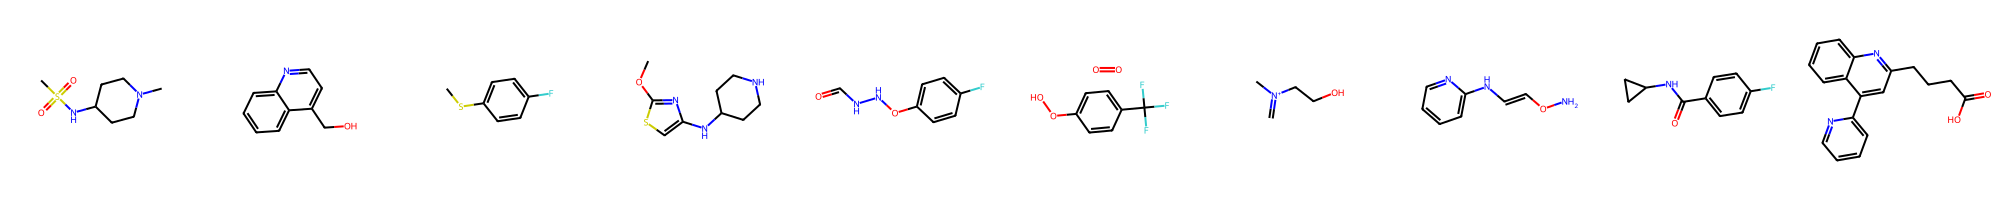

In [40]:
img = Draw.MolsToGridImage([decoding_res[i].molecule for i in range(len(decoding_res))], subImgSize=(200,200), maxMols = 1000, molsPerRow=10,)
img

# Con VAE

In [16]:
ckpt_path_con = '/data/conghao001/FYP/DrugDiscovery/ldm/lightning_logs/2023-05-04_12_17_09.756251/epochepoch=99-dropout=0.95-val_lossval/loss=0.43.ckpt'
ckpt_con = torch.load(ckpt_path_con, map_location = device)

In [15]:
config_file_con = '/data/conghao001/FYP/DrugDiscovery/ldm/lightning_logs/2023-05-04_12_17_09.756251/logs_2023-05-04_12_17_09.756251/version_0/ddim_vae_con.yml'
config_con = OmegaConf.load(config_file_con)
ldm_params_con = config_con['model']['params']

In [43]:
# first_stage_params = get_params(dataset)
first_stage_config = config_con['model']['first_stage_config']
ldm_params_con = config_con['model']['params']
unet_params_con = config_con['model']['unet_config']['params']
unet_params_con

{'use_spatial_transformer': True, 'image_size': 512, 'in_channels': 1, 'out_channels': 1, 'model_channels': 64, 'dims': 1, 'attention_resolutions': [4, 2], 'num_res_blocks': 1, 'channel_mult': [1, 2, 3], 'context_dim': 979, 'num_head_channels': 8}

In [44]:
con_vae_ldm = LatentDiffusion(
    first_stage_config,
    config_con['model']['cond_stage_config'],
    dataset, 
    batch_size,
    first_stage_params,
    first_stage_config['ckpt_path'],
    unet_config = config_con['model']['unet_config'],
    **ldm_params_con
)

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 8.91 M params.


In [57]:
con_vae_ldm.model.conditioning_key

'crossattn'

In [46]:
cond_sampler = MolSampler(con_vae_ldm)
cond_sampler

In [51]:
n_samples = 10
ge = one.gene_expressions[:n_samples,]
ge.size()

torch.Size([10, 978])

In [53]:
dose = one.dose[:n_samples]
cond = torch.cat((ge, dose.unsqueeze(-1)), dim=1)
cond.size()

torch.Size([10, 979])

In [54]:
conditioning = cond.view((n_samples, 1, unet_params_con.context_dim))
conditioning.size()

torch.Size([10, 1, 979])

In [59]:
samples, _ = cond_sampler.sample(
    S = ddim_steps,
    batch_size = n_samples,  # not batch size
    conditioning = conditioning,
    shape = size,
    ddim_eta = ddim_eta
)

samples

Selected timesteps for ddim sampler: [  1   5   9  13  17  21  25  29  33  37  41  45  49  53  57  61  65  69
  73  77  81  85  89  93  97 101 105 109 113 117 121 125 129 133 137 141
 145 149 153 157 161 165 169 173 177 181 185 189 193 197]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9946, 0.9904, 0.9859, 0.9810, 0.9756, 0.9698, 0.9635, 0.9568,
        0.9496, 0.9418, 0.9336, 0.9249, 0.9157, 0.9060, 0.8958, 0.8851, 0.8739,
        0.8622, 0.8500, 0.8373, 0.8241, 0.8105, 0.7964, 0.7819, 0.7670, 0.7516,
        0.7359, 0.7198, 0.7034, 0.6867, 0.6697, 0.6524, 0.6350, 0.6173, 0.5994,
        0.5814, 0.5633, 0.5451, 0.5269, 0.5087, 0.4905, 0.4724, 0.4543, 0.4364,
        0.4186, 0.4011, 0.3837, 0.3666, 0.3497]); a_(t-1): [0.99914998 0.99827701 0.99455011 0.99043489 0.98591566 0.98097759
 0.97560668 0.96978998 0.96351564 0.95677292 0.9495523  0.9418456
 0.93364584 0.92494762 0.91574699 0.90604162 0.89583057 0.88511467
 0.8738966  0.86218047 0.84997231 0.83727998 0.82411301 0.810

DDIM Sampler: 100%|█████████████████████████████████| 50/50 [00:04<00:00, 11.89it/s]


tensor([[[ 2.9230,  0.9639,  0.8896,  ..., -1.6340, -1.3932,  2.2602]],

        [[-1.9903,  0.2114,  3.4649,  ..., -1.0343, -0.6143,  0.9352]],

        [[-2.0824, -0.3528, -0.9906,  ..., -2.4339, -0.4103,  0.6103]],

        ...,

        [[-1.6943, -0.7312, -0.3463,  ...,  0.9638,  1.8966,  1.0553]],

        [[-1.6840, -0.4978, -3.1969,  ..., -1.5958, -0.6262, -2.1530]],

        [[-2.2317,  0.8837,  2.4200,  ..., -2.9354,  1.5370, -0.2774]]])

In [60]:
samples.size()

torch.Size([10, 1, 512])

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

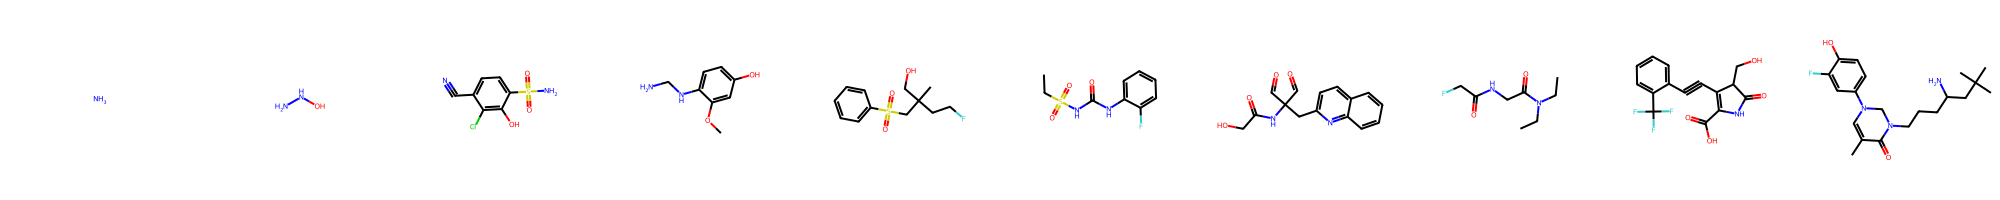

In [61]:
decoding_samples = samples.view((n_samples, unet_params_con.image_size))
decoding_res = con_vae_ldm.first_stage_model.decode(decoding_samples)
img = Draw.MolsToGridImage([decoding_res[i].molecule for i in range(len(decoding_res))], subImgSize=(200,200), maxMols = 1000, molsPerRow=10,)
img

# Uncon AAE

In [5]:
from ldm.moler_ldm import LatentDiffusion
from ldm.DDIM import MolSampler
import time

In [6]:
ckpt_path_aae = 'lightning_logs/2023-05-12_11_35_19.568394/epoch=24-step=944999.0-val_loss=0.13.ckpt'
ckpt_aae = torch.load(ckpt_path_aae, map_location = device)

In [7]:
config_file_aae = 'config/ldm_uncon+aae_uncon.yml'
config_aae = OmegaConf.load(config_file_aae)
# ldm_params = config_aae['model']['params']

In [8]:
dataset = MolerDataset(
    root="/data/ongh0068",
    raw_moler_trace_dataset_parent_folder="/data/ongh0068/guacamol/trace_dir",
    output_pyg_trace_dataset_parent_folder="/data/ongh0068/l1000/already_batched",
    split="valid_0",
)

In [9]:
first_stage_params = get_params(dataset)
first_stage_config = config_aae['model']['first_stage_config']
ldm_params = config_aae['model']['params']
unet_params = config_aae['model']['unet_config']['params']
batch_size = 1
drop_prob = 0.0
latent_space_dim = int(ldm_params['image_size'])
size = [1, latent_space_dim]

In [10]:
model = LatentDiffusion(
    first_stage_config,
    config_aae['model']['cond_stage_config'],
    dataset, 
    drop_prob,
    batch_size,
    first_stage_params,
    first_stage_config['ckpt_path'],
    unet_config = config_aae['model']['unet_config'],
    **ldm_params
)

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 3.49 M params.


In [11]:
model.load_state_dict(ckpt_aae['state_dict'])
model = model.to(device)
model.eval()

LatentDiffusion(
  (model): DiffusionWrapper(
    (diffusion_model): UNetModel(
      (time_embed): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (1): TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=256, out_features=64, bias=True)
            )
            (out_layers): Sequential(
              (0): GroupNorm32(32, 64, e

In [15]:
sampler = MolSampler(model)
number_samples = 1000
internal_bs = 1000
steps = int(number_samples / internal_bs)
size = [1, latent_space_dim]
ddim_steps = 50
ddim_eta = 1.0

In [16]:
start_time = time.time()

for step in tqdm(range(steps)):
    z_samples, _ = sampler.sample(
        S = ddim_steps,
        batch_size = internal_bs,  # not batch size
        shape = size,
        ddim_eta = ddim_eta
    )
    if step == 0:
        z = z_samples.view((internal_bs, latent_space_dim))
    else:
        tmp_z = z_samples.view((internal_bs, latent_space_dim))
        z = torch.cat((z, tmp_z), dim = 0)
# print("z shape: ", self.z.shape)
print("Finished sampling z")
z_time = time.time()

decoder_states = model.first_stage_model.decode(
    latent_representations=z, max_num_steps=120
)
# decoder_states = decoder_states.cpu()
# self.release_gpu_memory(self.model, self.ckpt)
# self.samples = [
#     Chem.MolToSmiles(decoder_state.molecule) for decoder_state in decoder_states
# ]

end_time = time.time()

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.52153981 0.4881804  0.45523876 0.42288151 0.39126703 0.36


  0%|                                                     | 0/1 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.91 GiB (GPU 0; 15.89 GiB total capacity; 5.10 GiB already allocated; 3.03 GiB free; 9.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
print(z_time - start_time)
print(end_time - z_time)
print(end_time - start_time)

32.57977819442749
223.32818055152893
255.90795874595642


In [14]:
z.shape

torch.Size([1000, 512])

In [15]:
z.device

device(type='cuda', index=1)